In [9]:
from utils.tools import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = connection_db_sql('wines_data', "SELECT density, quality, residual_sugar, alcohol FROM winequality")
data['gt_density'] = data.density > data.density.median()
data.head()

,density,quality,residual_sugar,alcohol,gt_density
0,0.9978,5,1.9,9.4,True
1,0.9968,5,2.6,9.8,True
2,0.9970,5,2.3,9.8,True
3,0.9980,6,1.9,9.8,True
4,0.9978,5,1.9,9.4,True


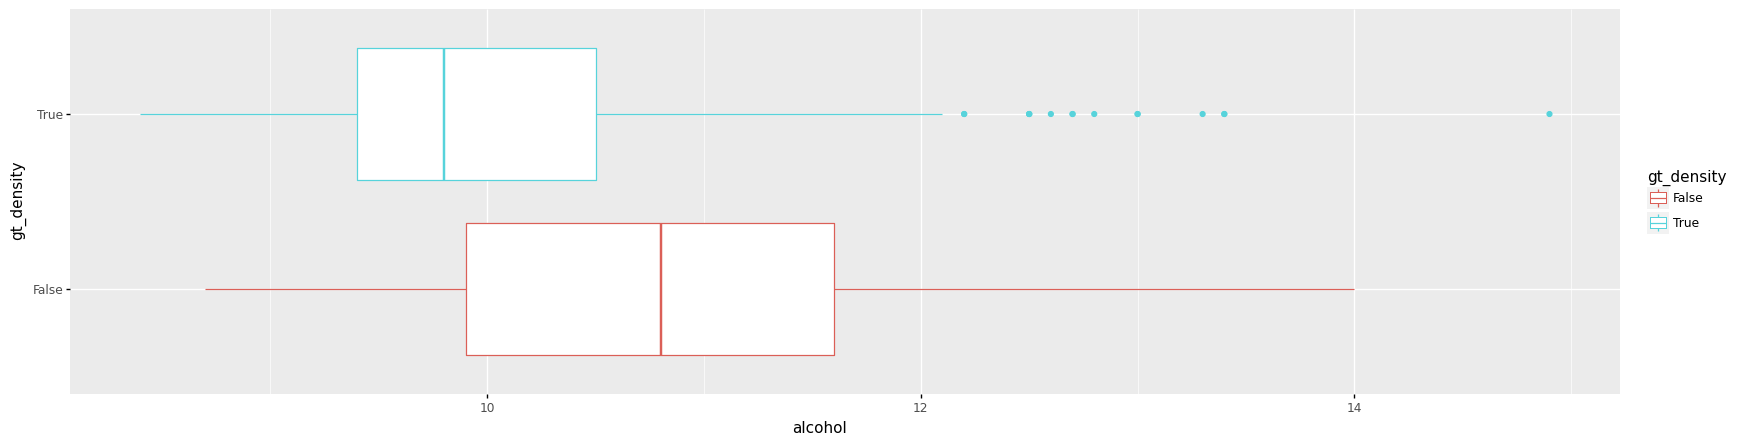

In [3]:
graf_boxplot(data, 'gt_density', 'alcohol')

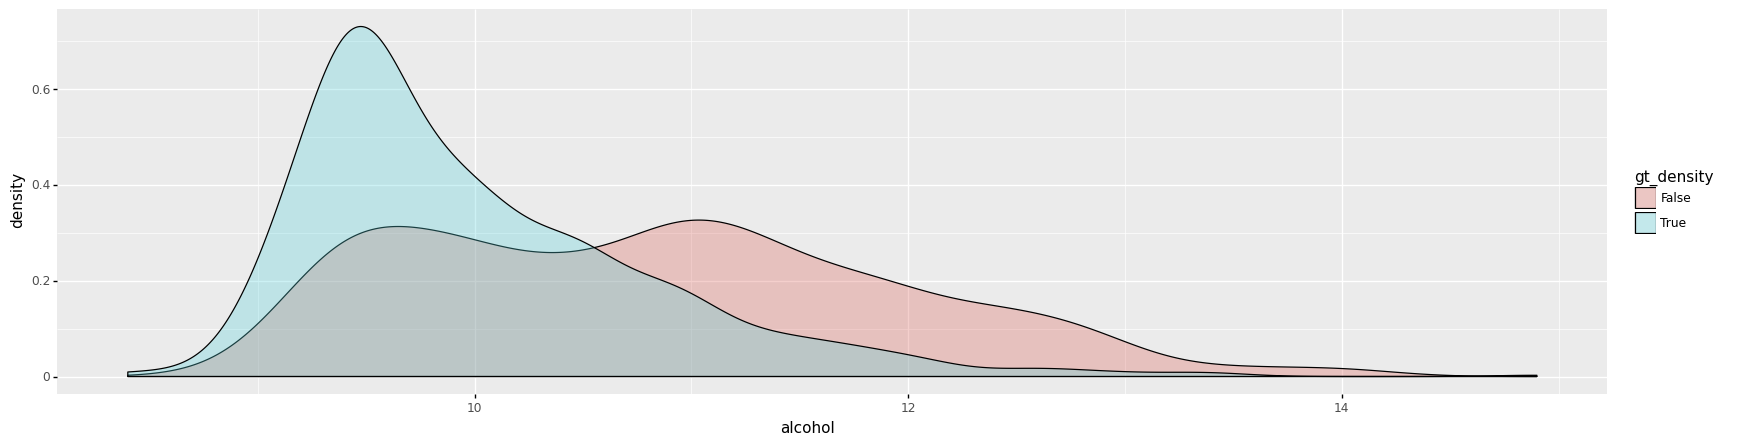

In [4]:
graf_density(data, 'alcohol', 'gt_density')

Now, Can visualace the data is balance between categories.

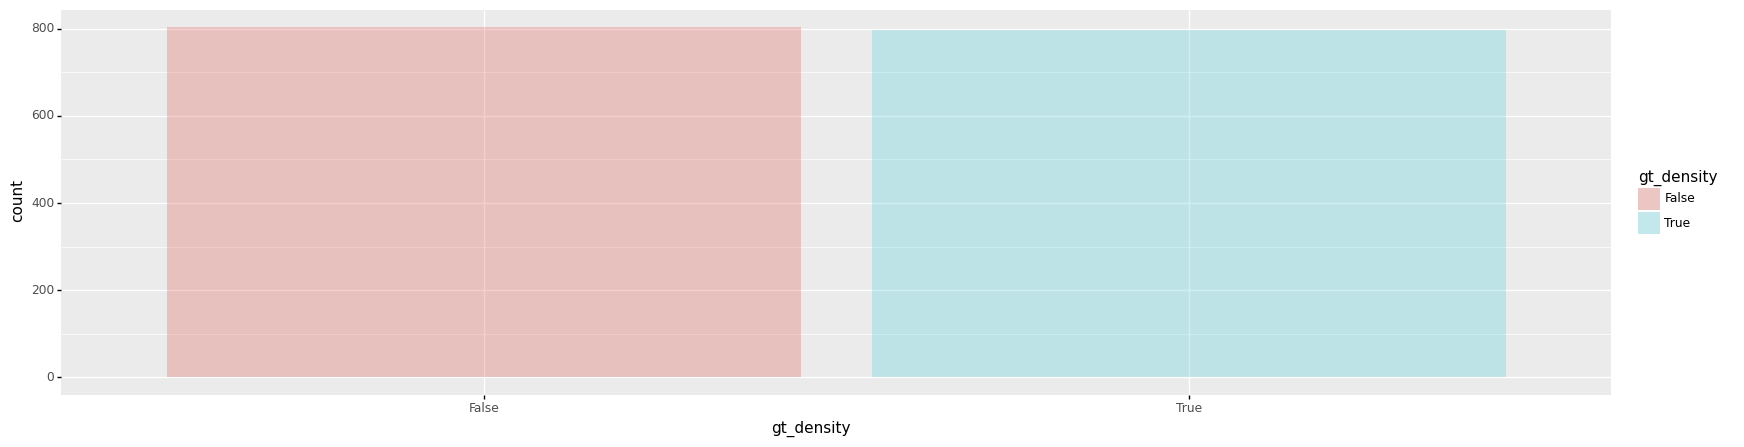

In [5]:
graf_bar(data, 'gt_density')

In [6]:
data[['quality', 'gt_density']].groupby('gt_density').count()

,quality
gt_density,
False,803
True,796


## Building of model

In [7]:
# División de los datos en train y test
X = data[['alcohol']]
y = data['gt_density']

X_train, X_test, y_train, y_test = train_test_split(
                                        X.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación del modelo
lr=LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create randomized search 5-fold cross validation and 100 iterations
clf = RandomizedSearchCV(lr, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)

# Fit randomized search
best_model = clf.fit(X, y)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])


#Building Model again with best params
lr2=LogisticRegression(C=best_model.best_estimator_.get_params()['C'],penalty=best_model.best_estimator_.get_params()['penalty'])
lr2.fit(X_train,y_train)

# predict probabilities on Test and take probability for class 1([:1])
y_pred_prob_test = lr2.predict_proba(X_test)[:, 1]
#predict labels on test dataset
y_pred_test = lr2.predict(X_test)
# create onfusion matrix
cm = confusion_matrix(y_test, y_pred_test)
print("confusion Matrix is :nn",cm)
print("n")
# ROC- AUC score
print("ROC-AUC score  test dataset:  t", roc_auc_score(y_test,y_pred_prob_test))
#Precision score
print("precision score  test dataset:  t", precision_score(y_test,y_pred_test))
#Recall Score
print("Recall score  test dataset:  t", recall_score(y_test,y_pred_test))


Best Penalty: l2
Best C: 3.730229437354635
confusion Matrix is :nn [[ 96  61]
 [ 43 120]]
n
ROC-AUC score  test dataset:  t 0.7229690125434722
precision score  test dataset:  t 0.6629834254143646
Recall score  test dataset:  t 0.7361963190184049


In [10]:
graf_roc(y_test, X_test, lr2)

<AxesSubplot:xlabel='alcohol', ylabel='gt_density'>

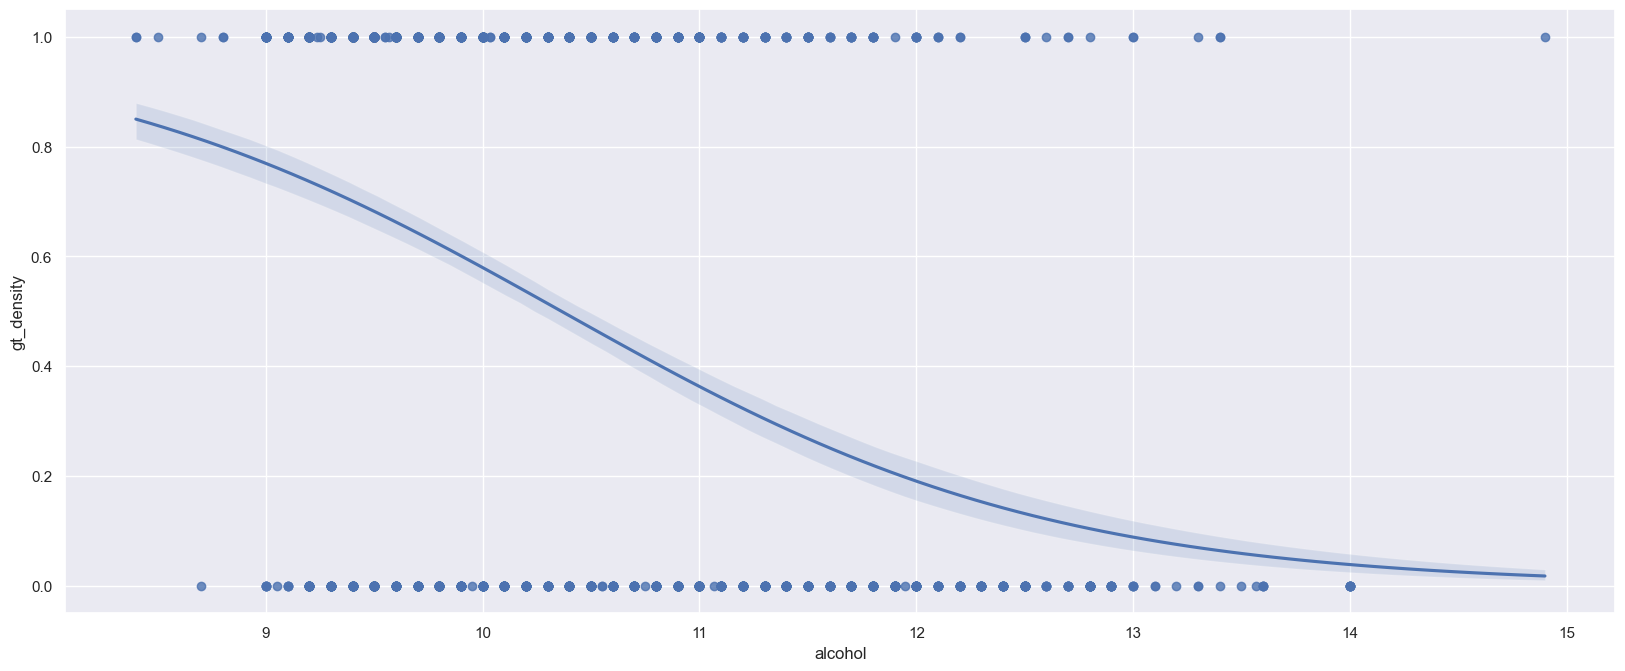

In [50]:
import seaborn as sns; sns.set_theme(color_codes=True)
plt.rcParams.update({'figure.figsize':(20,8), 'figure.dpi':100})
#plot logistic regression curve with black points and red line
sns.regplot(x=X, y=y, data=data, logistic=True, ci=95)